# Homework 2 Rosini Micol

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Utils cell
def extract_time(node_rates: np.array) -> np.array: 
    return -np.log(np.random.uniform(size=len(node_rates)))/(node_rates +1e-10)
    #return -np.log(np.random.uniform(size=len(node_rates)))/(node_rates)


def update_rate(nop, w1, input_rate=1):
    rate = nop * w1
    rate[0] = input_rate
    return rate

def update_fixed_rate(rate,nop,w1, input_rate):
    rate[0] = input_rate
    for i in range(1,len(nop)):
        
        if nop[i] == 0:
            rate[i] = 0
        else:
            rate[i] = w1[i]
        
    return rate

def move(start_node, Q, numb_part): 
    if numb_part[start_node] > 0:
        numb_part[start_node] -= 1
        if start_node != 5:
            if start_node == 0:
                numb_part[start_node] += 1
                end_node = 1
                numb_part[end_node] += 1
            else: 
                end_node = np.random.choice(list(range(1,6)), p=Q[start_node-1,:])
                numb_part[end_node] += 1
    return numb_part


def particle_movements(nodes_rate, Q, nop, w1, fixed = False, input_rate=1):
    global_time = 0 
    t = list() # Track the time of movements
    v = list() # Track status (nr of particles) of the nodes 
    min_time = 0 
    node_chosen = 0
    nop = np.zeros(6)
    nop[0] = 1
    
    while global_time <= 60:
        times_node = extract_time(nodes_rate)
        times_node -= min_time 
        times_node[node_chosen] += 2 * min_time 

        node_chosen = np.argmin(times_node)
        min_time = np.min(times_node)
        
        numb_of_part = list(move(node_chosen, Q, nop))
        if not fixed:
            nodes_rate = update_rate(nop, w1)
        else:
            nodes_rate = update_fixed_rate(nodes_rate,nop, w1, input_rate)
        nodes_rate[0] = input_rate
        if min_time < 0:
            min_time = -min_time

        global_time += min_time
        t.append(global_time)
        v.append(numb_of_part)

    return t, np.array(v).astype(int)

## Exercise 3

Consider the open network of the figure above, with transition rate matrix $\Lambda_{open}$:

<div class="math">
    \[\begin{array}{1}& o && a && b && c && d\end{array}\\
        %\begin{array}{1} & o && a && b && c & d\end{array}\\
        \Lambda_{open} = 
        \begin{pmatrix}
         0 & 3/4 & 3/8 & 0 & 0 \\
         0 & 0 & 1/4 & 1/4 & 2/4 \\
         0 & 0 & 0 & 1 & 0 \\
         0 & 0 & 0 & 0 & 1 \\
         0 & 0 & 0 & 0 & 0 
        \end{pmatrix}
        \begin{array}{1}
         o \\ a \\ b \\ c \\ d
        \end{array}
      \] 
</div>

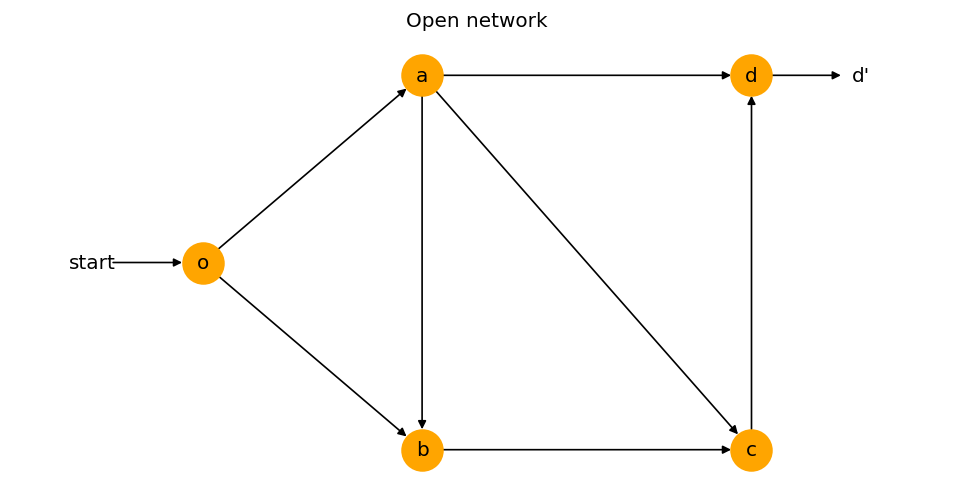

In [3]:
fig, ax = plt.subplots(figsize = (10,5), dpi=120) 

nodes = ['o', 'a', 'b', 'c', 'd','start',"d'"]

positions = [(-0.5, 0.5), (0.5, 1), (0.5, 0), (2, 0), (2, 1),(-1,0.5),(2.5,1)]
edges = [('o', 'a'), ('o', 'b'), ('a', 'b'), ('a', 'c'),('b','c'),('a','d'),('c','d'),('start','o'),('d',"d'")]

G1 = nx.DiGraph()
weights = {'start':{'o':1,}, 'o':{'a':2/3,'b':1/3}, 'a':{'b':1/4,'c':1/4,'d':2/4}, 'b':{'c':1}, 'c':{'d':1}, 'd':{"d'":1}}
edge_list = [(u,v,w) for u,e in weights.items() for v,w in e.items()]
G1.add_weighted_edges_from(edge_list)



for index, name in enumerate(nodes):
    G1.add_node(name, pos=positions[index])
    
node_color =['white' if x in ('start',"d'")  else 'orange' for x in G1.nodes()]
node_list =list( G1.nodes())
node_list.remove('start')
node_list.remove("d'")

layout = dict((n, G1.nodes[n]["pos"]) for n in G1.nodes())


arc_rad = -0.3

nx.draw(G1, pos=layout, with_labels=True, node_size=600, node_color = 'orange', nodelist=node_list, edgelist = edges)

ax.set_title("Open network")


plt.savefig('fig/graph14.png')

In [4]:
# Graph settings
nodes_original = ['o', 'a', 'b', 'c', 'd']
edges_original = [('o', 'a'), ('o', 'b'), ('a', 'b'), ('a', 'c'),('b','c'),('a','d'),('c','d')]
G = nx.DiGraph()
G.add_nodes_from(nodes_original)
G.add_edges_from(edges_original)
 
lambda_open =[[0, 3/4, 3/8, 0, 0],
          [0, 0, 1/4, 1/4, 2/4],
          [0, 0, 0, 1, 0],
          [0, 0, 0, 0, 1],
          [0, 0, 0, 0, 0]]


w = np.sum(lambda_open, axis=1)
w_star = np.max(w)


Q = lambda_open/w_star 
Q = Q + np.diag(np.ones(len(w))-np.sum(Q, axis = 1))

# dominant eigevector
values,vectors = np.linalg.eig(Q.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
nstates = len(pi_bar)

D = np.diag(w)

# Transition probability matrix
P_bar = lambda_open /w_star
P_bar -= np.diag(P_bar)
P_bar += np.diag(1 - w/w_star*(1-np.diag(P_bar)))

For this system, particles will enter the system at node $o$ according to a Poisson process with input rate $\lambda = 1$. Each node will then pass along a particle according to a given rate. Let $\omega = \Lambda\mathbf{1}$ and let $N(t)$ denote the vector of number of particles in each node at time ***t***.
Let's simulate two different scenarios that differ by what rate the nodes will pass along particles: 

- proportional rate

- fixed rate

## a ) Proportional rate

Each node will pass along particles according to a Poisson process with rate equal to the number of particles in the node times the rate of the local Poisson clock of node $i$, i.e., the node $i$ will pass along particles rate with rate $\omega_iN_i(t)$.
Since node $d$ does not have a node to send its particles to, we assume that $\omega_d = 2$. When the Poisson clock ticks for this node you could simply decrease the number of particles in the node by one (if there are any particles in the node). Equivalently think of another node d′ connected to node d, such that at every tick of the Poisson clock of d, it sends a particle to node d′.

- Simulate the system for 60 time units and plot the evolution of the number of particles in each node over time.
- What is the largest input rate that the system can handle without blowing up?



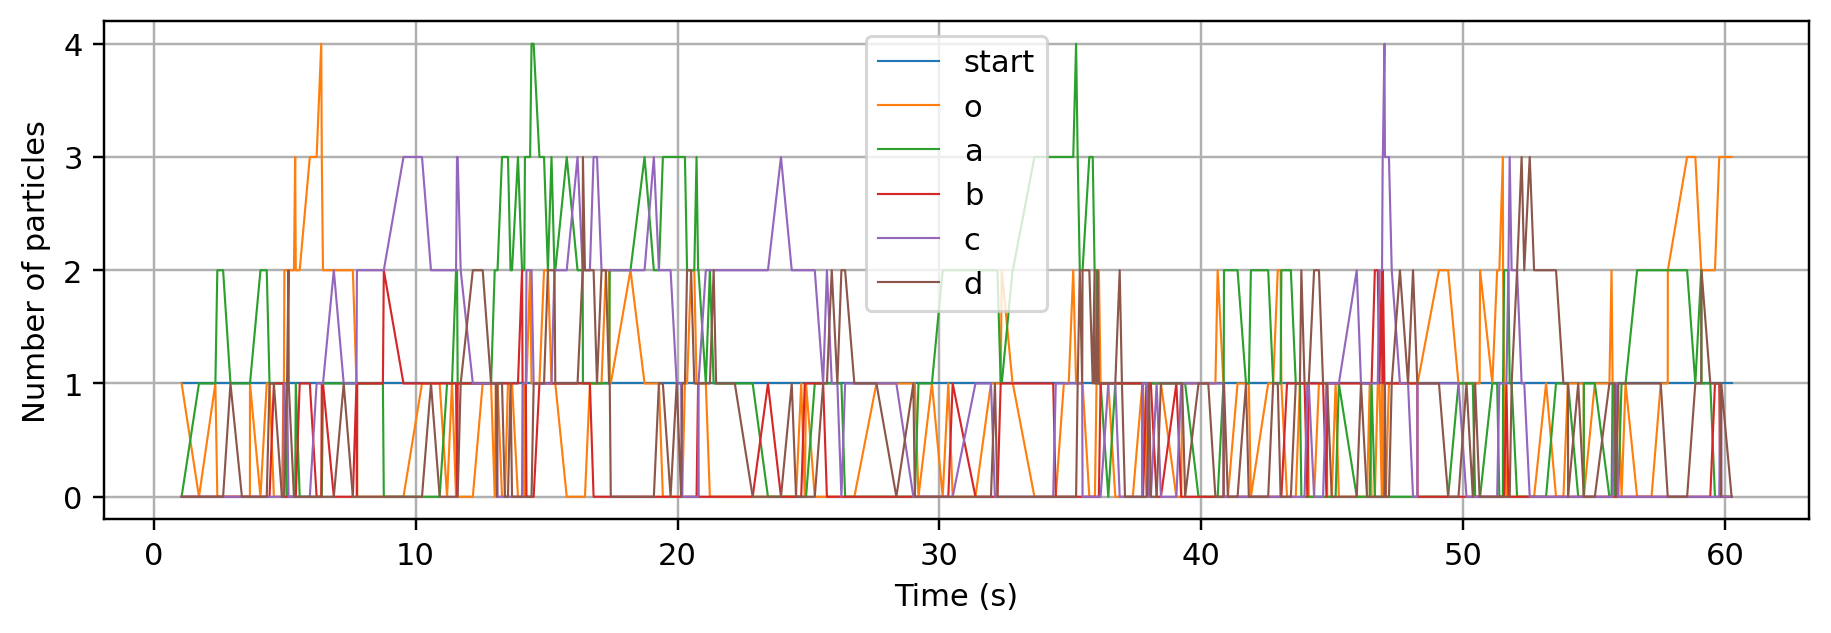

In [5]:
nodes = list(G1.nodes()) # " 'start, o, a, b, c, d, d' "

nodes = nodes[:-1] # removing d'
w1 = np.insert(w, 0, 1) #w_start = 1
w1[-1] = 2 # w_d = 2


nodes_rate = np.array([1, 0, 0, 0, 0, 2])
nop = np.zeros(len(nodes))
nop[0] = 1

t, v = particle_movements(nodes_rate, Q, nop, w1)
v = np.array(v).astype(int) 

fig, ax = plt.subplots(figsize=[10,3], dpi= 220)
for col, node in zip(range(v.shape[1]), nodes):
    ax.plot(t, v[:,col], label= node, linewidth=0.7)
ax.legend()
ax.grid()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Number of particles")

plt.savefig('fig/graph15.png')
plt.show()


The system can handle any input rate without blowing up, because the rate a node passes along particles is proportional to the number of particles in the node, so when there will be a great number of particles in the system, a lot of them will move from a node inside the graph and not from the input.

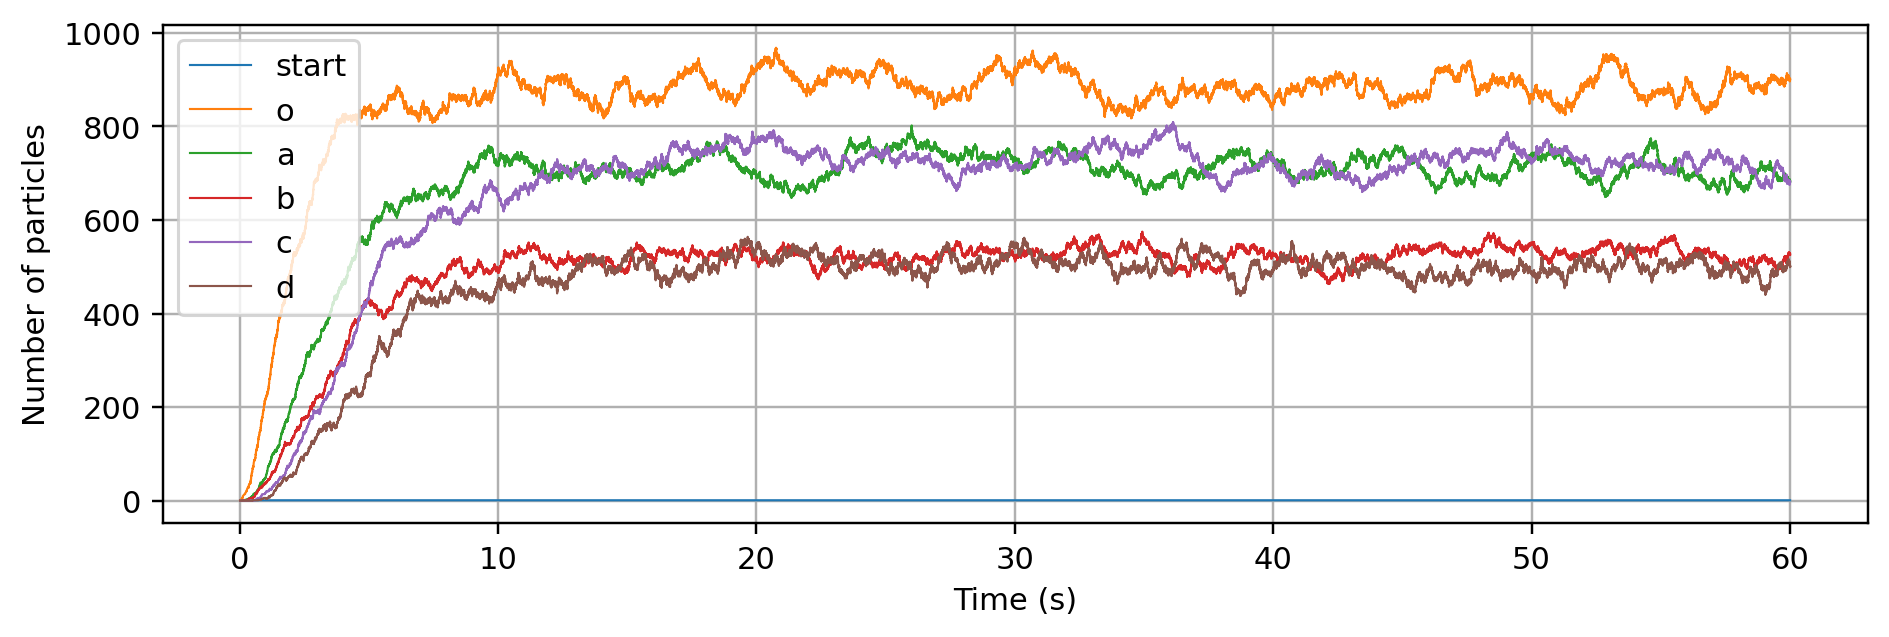

In [6]:
t, v = particle_movements(nodes_rate, Q, nop, w1, input_rate=1000)
v = np.array(v).astype(int) 

fig, ax = plt.subplots(figsize=[10,3], dpi= 220)
for col, node in zip(range(v.shape[1]), nodes):
    ax.plot(t, v[:,col], label= node, linewidth=0.7)
ax.legend()
ax.grid()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Number of particles")

plt.savefig('fig/graph16.png')
plt.show()

## b ) Fixed rate

Each node i will instead pass along particles with a fixed rate $\omega_i$.
- Simulate the system for 60 time units and plot the evolution of the number of particles in each node over time.
- What is the largest input rate that the system can handle without blowing up?

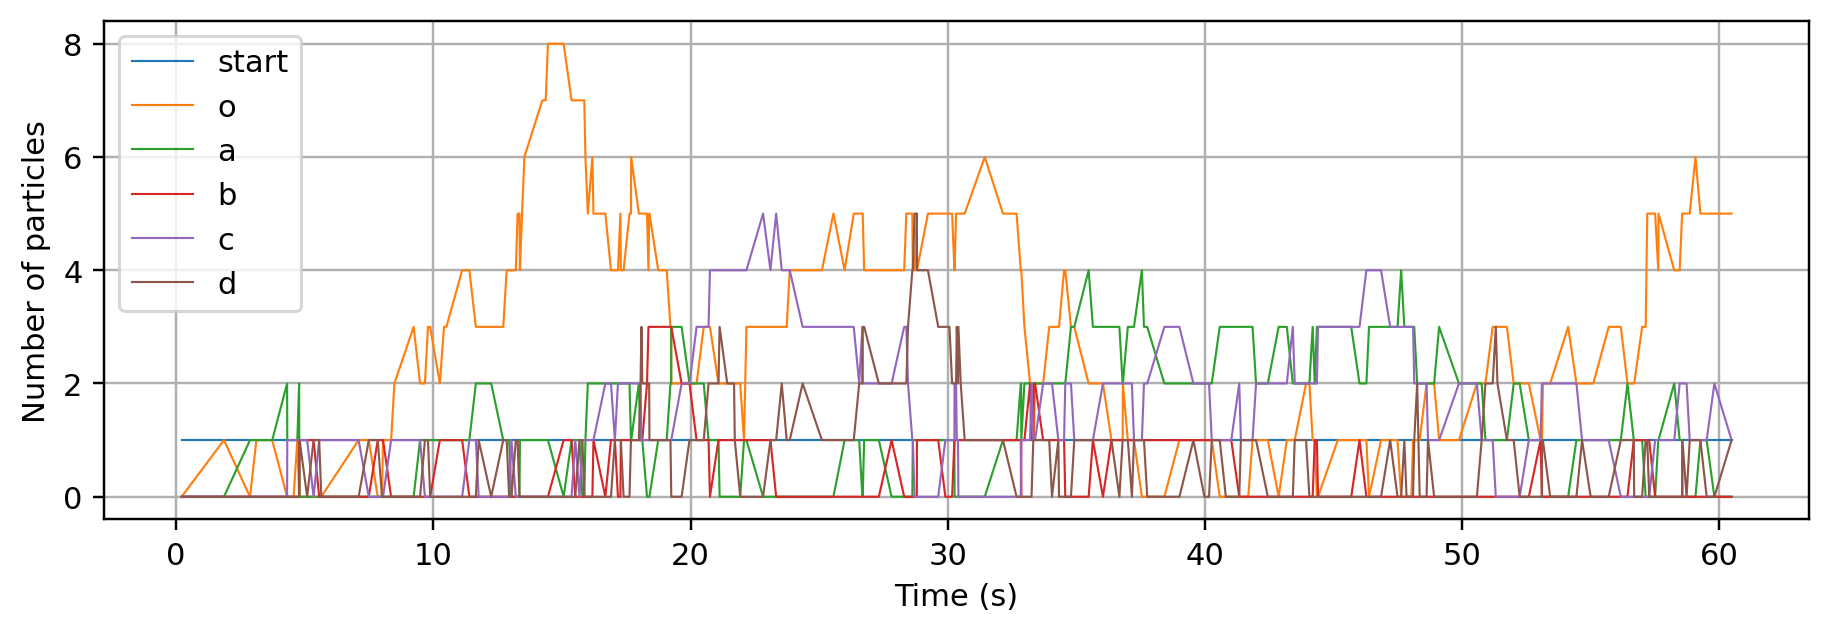

In [7]:
t_f, v_f = particle_movements(nodes_rate, Q, nop, w1, fixed=True, input_rate = 1)
v_f = np.array(v_f).astype(int) 
fig, ax = plt.subplots(figsize=[10,3], dpi= 220)
for col, node in zip(range(v_f.shape[1]), nodes):
    ax.plot(t_f, v_f[:,col], label= node, linewidth=0.7)
ax.legend()
ax.grid()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Number of particles")

plt.savefig('fig/graph17.png')
plt.show()

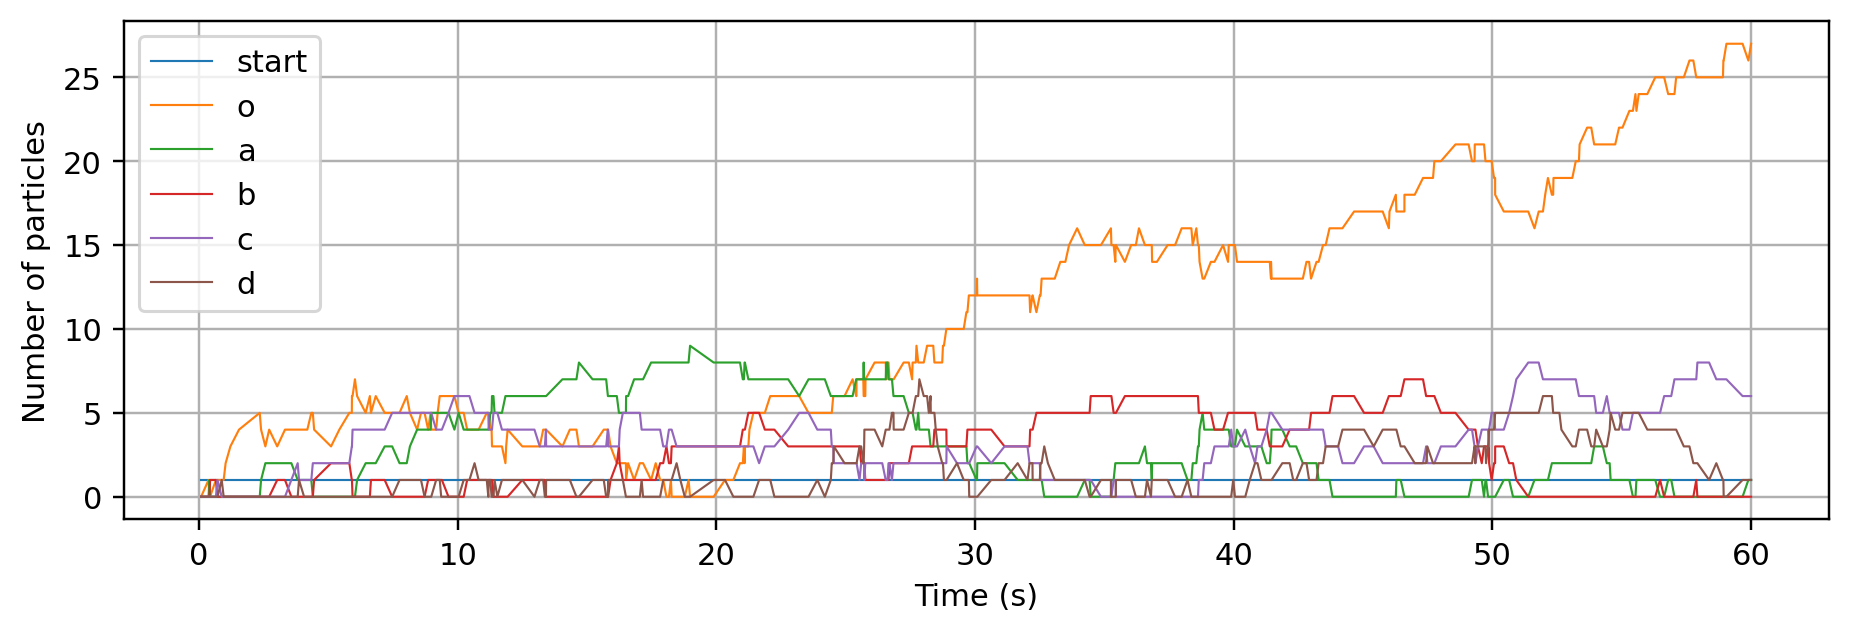

In [8]:
t_f, v_f = particle_movements(nodes_rate, Q, nop, w1, fixed=True, input_rate=2)
v_f = np.array(v_f).astype(int) 

fig, ax = plt.subplots(figsize=[10,3], dpi= 220)
for col, node in zip(range(v_f.shape[1]), nodes):
    ax.plot(t_f, v_f[:,col], label= node, linewidth=0.7)
ax.legend()
ax.grid()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Number of particles")
plt.savefig('fig/graph18.png')
plt.show()
